In [620]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import seaborn as sns


from sklearn.preprocessing import normalize
import matplotlib.pyplot  as  plt
tqdm.pandas()
import itertools

In [2]:
#считывание данных
users = pd.read_csv('train/users.csv', sep=';', index_col=None, 
                    dtype={'age': str, 'chb': str, 'chit_type': str, 'gender': str})
items = pd.read_csv('train/items.csv', sep=';', index_col=None, 
                    dtype={'author': str, 'bbk': str, 'izd': str, 'sys_numb': str, 'title': str, 'year_izd': str})
train_transactions = pd.read_csv('train/train_transactions_extended.csv', sep=';', index_col=None, 
                                 dtype={'chb': str, 'date_1': str, 'is_printed': str, 'is_real': str, 'source': str, 'sys_numb': str, 'type': str})

# Очищаем результаты от пустых значений
#                   книги

In [3]:
def aut_non(a):                      # уберем значения которые не несут смысловую нагрузку
    if a =='отсутствует' or a =='none' or a=='None' or a == 'нет данных' or a == 'не указан':
        return None
    else:
        return a

<AxesSubplot:>

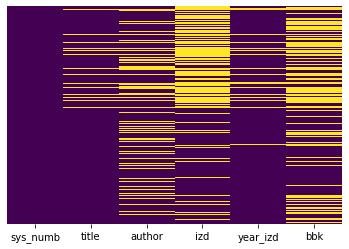

In [4]:
items['author'] = items['author'].apply(lambda x: aut_non(x))
items['title'] = items['title'].apply(lambda x: aut_non(x))
items['izd'] = items['izd'].apply(lambda x: aut_non(x))
items['year_izd'] = items['year_izd'].apply(lambda x: aut_non(x))
items['bbk'] = items['bbk'].apply(lambda x: aut_non(x))
sns.heatmap(items.isnull(), yticklabels=False, cbar=False, cmap='viridis')

# пользователи

In [5]:
users['age'] = users['age'].apply(lambda x: aut_non(x))
users['chb'] = users['chb'].apply(lambda x: aut_non(x))
users['chit_type'] = users['chit_type'].apply(lambda x: aut_non(x))
users['gender'] = users['gender'].apply(lambda x: aut_non(x))

<AxesSubplot:>

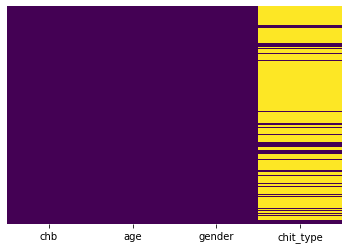

In [6]:
sns.heatmap(users.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [7]:
users[users['gender'].isnull()]

,chb,age,gender,chit_type
199,300000807978,61,None,None
376,300000830295,39,None,normal
2817,200000457581,38,None,normal
3584,100000764843,70,None,None
3621,100000683677,49,None,None
5080,200000968175,39,None,None
6119,100001025944,69,None,None
6477,100000820607,45,None,None
6662,200000831671,58,None,None
6670,100000983523,58,None,None


In [8]:
users['gender'].unique()

array(['female', 'male', None], dtype=object)

# выданные книги

In [9]:
train_transactions.head()

,chb,sys_numb,date_1,is_real,type,source,is_printed
0,100000641403,RSL01004206702,2021-02-21,yes,скачивание,dlib.rsl.ru,False
1,100000641403,RSL01000769304,2021-03-23,yes,скачивание,dlib.rsl.ru,False
2,100000641403,RSL01004211574,2021-02-21,yes,скачивание,dlib.rsl.ru,False
3,100000644359,RSL01009800093,2021-03-16,yes,книговыдача,единый просмоторщик,False
4,100000644359,RSL01003557352,2021-03-10,yes,книговыдача,единый просмоторщик,False


In [10]:
train_transactions['is_printed'].unique()

array(['False', 'True'], dtype=object)

In [11]:
from prophet import Prophet

In [12]:
train_transactions['source'].unique()

array(['dlib.rsl.ru', 'единый просмоторщик', 'None', '2DL.Viewer'],
      dtype=object)

In [13]:
# объеденим в один dataset

In [14]:
df = train_transactions.merge(items, on='sys_numb')

In [15]:
df = df.merge(users, on='chb')

<AxesSubplot:>

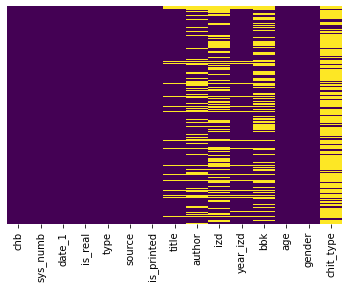

In [16]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [17]:
df.dropna(subset=['title'], inplace=True) # удалим пустые 
df.reset_index(drop=True, inplace=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240324 entries, 0 to 240323
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   chb         240324 non-null  object
 1   sys_numb    240324 non-null  object
 2   date_1      240324 non-null  object
 3   is_real     240324 non-null  object
 4   type        240324 non-null  object
 5   source      240324 non-null  object
 6   is_printed  240324 non-null  object
 7   title       240324 non-null  object
 8   author      190418 non-null  object
 9   izd         157337 non-null  object
 10  year_izd    238739 non-null  object
 11  bbk         164026 non-null  object
 12  age         240321 non-null  object
 13  gender      239956 non-null  object
 14  chit_type   57596 non-null   object
dtypes: object(15)
memory usage: 27.5+ MB


<AxesSubplot:>

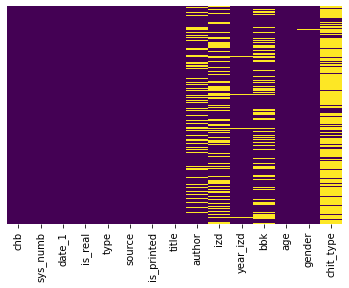

In [19]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [20]:
df.drop(['chit_type', 'is_real', 'type', 'source', 'is_printed'], axis=1, inplace=True)

In [21]:
df['date_1']=pd.to_datetime(df['date_1']) # преобразовал даты в даты

In [22]:
df.head()

,chb,sys_numb,date_1,title,author,izd,year_izd,bbk,age,gender
0,100000641403,RSL01004206702,2021-02-21,Придание огнестойкости деревянным постройкам,"Максимов, Владимир Лаврович",Гл. упр. землеустройства и земледелия,1915,None,55,male
1,100000641403,RSL01000769304,2021-03-23,"Медицинская, научная и общественная деятельнос...","Шалаев, Николай Федорович",None,1993,None,55,male
2,100000641403,RSL01004211574,2021-02-21,Кирпичная изба,"Максимов, Владимир Лаврович",М-во зем.,1916,None,55,male
3,200000854633,RSL01004211574,2021-01-26,Кирпичная изба,"Максимов, Владимир Лаврович",М-во зем.,1916,None,29,male
4,200000854633,RSL01004185091,2021-06-10,Кулинарный сборник : 1-е изд. : Рецепты кушани...,None,None,1915,None,29,male


In [23]:
temper_t = df['sys_numb'].value_counts()

In [24]:
df['touch_book']=df['sys_numb'].progress_apply(lambda x: temper_t[x])

  0%|          | 0/240324 [00:00<?, ?it/s]

In [25]:
temper = df['chb'].value_counts()

In [26]:
df['get_book_u']=df['chb'].progress_apply(lambda x: temper[x])

  0%|          | 0/240324 [00:00<?, ?it/s]

In [27]:
df.head()

,chb,sys_numb,date_1,title,author,izd,year_izd,bbk,age,gender,touch_book,get_book_u
0,100000641403,RSL01004206702,2021-02-21,Придание огнестойкости деревянным постройкам,"Максимов, Владимир Лаврович",Гл. упр. землеустройства и земледелия,1915,None,55,male,1,3
1,100000641403,RSL01000769304,2021-03-23,"Медицинская, научная и общественная деятельнос...","Шалаев, Николай Федорович",None,1993,None,55,male,1,3
2,100000641403,RSL01004211574,2021-02-21,Кирпичная изба,"Максимов, Владимир Лаврович",М-во зем.,1916,None,55,male,2,3
3,200000854633,RSL01004211574,2021-01-26,Кирпичная изба,"Максимов, Владимир Лаврович",М-во зем.,1916,None,29,male,2,26
4,200000854633,RSL01004185091,2021-06-10,Кулинарный сборник : 1-е изд. : Рецепты кушани...,None,None,1915,None,29,male,3,26


In [28]:
df['age'].isnull().sum() #----------------------------------------

3

In [29]:
df['age'] = df['age'].fillna('20') # т.к. только один человек не указал свой возраст и судя по книгам 
                                   # можно предположить что это студент 20 л.

In [30]:
df['age'] = df['age'].astype('int64')

In [31]:
df.describe().round(2)

,age,touch_book,get_book_u
count,240324.00,240324.00,240324.00
mean,39.93,1.99,386.97
std,16.44,2.16,1268.81
min,0.00,1.00,1.00
25%,25.00,1.00,12.00
50%,37.00,1.00,31.00
75%,51.00,2.00,100.00
max,95.00,44.00,6755.00


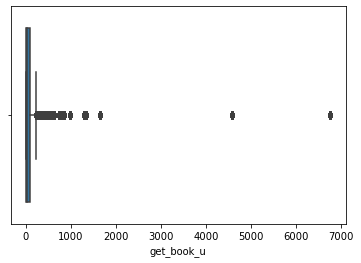

In [32]:
ax=sns.boxplot(x='get_book_u', data=df) # определим выбросы по взятым книгам


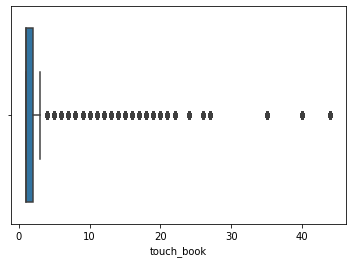

In [33]:
ax=sns.boxplot(x='touch_book', data=df) # определим выбросы по популярности книги


[(1.0, 200.0)]

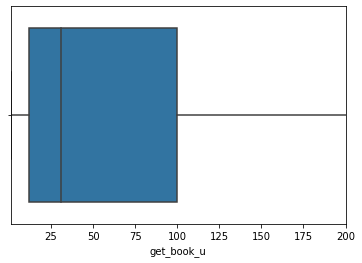

In [34]:
ax=sns.boxplot(x='get_book_u', data=df) # определим выбросы по взятым книгам
ax.set(xlim=(1, 200))

In [35]:
import scipy.stats as sps
ddf = sps.trim_mean(df['get_book_u'], 0.1 )

In [36]:
ddf

65.38035992926245

In [37]:
Q1 = df['get_book_u'].quantile(q=.05)
Q3 = df['get_book_u'].quantile(q=.9)
#IQR = df['get_book_u'].apply(sps.iqr)

#only keep rows in dataframe that have values within 1.5\*IQR of Q1 and Q3
df_N_gb = df[(df['get_book_u'] > Q1) & (df['get_book_u'] < Q3)].copy()
print(Q1)
print(Q3)


4.0
523.0


In [38]:
df_N_gb.describe().round(2)

,age,touch_book,get_book_u
count,197347.00,197347.00,197347.00
mean,38.58,2.09,62.96
std,15.72,2.29,82.55
min,14.00,1.00,5.00
25%,25.00,1.00,13.00
50%,35.00,1.00,30.00
75%,49.00,2.00,73.00
max,95.00,44.00,515.00


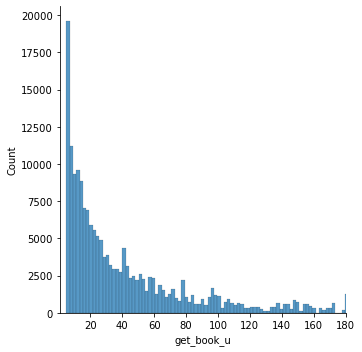

In [39]:
ax = sns.displot(data=df_N_gb['get_book_u']) # определим выбросы по взятым книгам
ax.set(xlim=(1, 180))

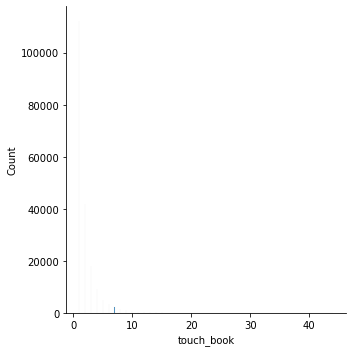

In [40]:
ax = sns.displot(data=df_N_gb['touch_book']) # определим выбросы по популярности книги

In [41]:
print('количество книг с разными подразделами согласно шифров ББК ', df['bbk'].nunique(), '- шт.')
print('количчество книг с связанными тематиками',  df['bbk'].str[:3].nunique(), '- шт.')
df['bbk']=df['bbk'].str[:3] # оставляем похожие тематики.

количество книг с разными подразделами согласно шифров ББК  79097 - шт.
количчество книг с связанными тематиками 1345 - шт.


In [42]:
print('количество книг с разным номером всего взятых', df['sys_numb'].count(), '- шт.')
print('количество книг с одинаковым названием',  df['title'].nunique(), '- шт.')

количество книг с разным номером всего взятых 240324 - шт.
количество книг с одинаковым названием 176722 - шт.


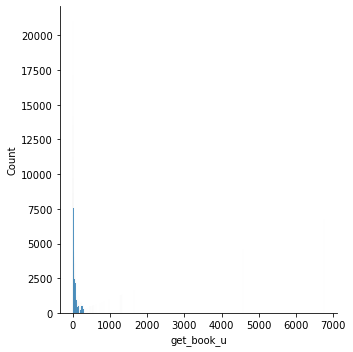

In [43]:
sns.displot(data=df['get_book_u'])

In [44]:
df_title = pd.DataFrame(df['title'].unique(), columns=['title'] )

In [45]:
df_title['new_sys_numb'] = range(1, len(df_title) + 1)

In [646]:
df_title.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176722 entries, 0 to 176721
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   title         176722 non-null  object
 1   new_sys_numb  176722 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.7+ MB


In [47]:
df = df_N_gb.merge(df_title, on='title')

<AxesSubplot:>

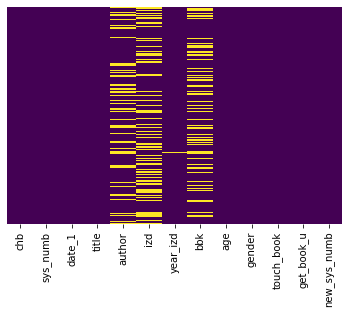

In [48]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [49]:
d = {'female':0, 'male':1, None:2}
df['gender'] = df['gender'].apply(lambda x:d[x])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197347 entries, 0 to 197346
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   chb           197347 non-null  object        
 1   sys_numb      197347 non-null  object        
 2   date_1        197347 non-null  datetime64[ns]
 3   title         197347 non-null  object        
 4   author        153541 non-null  object        
 5   izd           132957 non-null  object        
 6   year_izd      196037 non-null  object        
 7   bbk           137944 non-null  object        
 8   age           197347 non-null  int64         
 9   gender        197347 non-null  int64         
 10  touch_book    197347 non-null  int64         
 11  get_book_u    197347 non-null  int64         
 12  new_sys_numb  197347 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(7)
memory usage: 21.1+ MB


In [50]:
df['bbk']=df['bbk'].str[:3] # оставляем похожие тематики.
df[df['gender'] == 2]

,chb,sys_numb,date_1,title,author,izd,year_izd,bbk,age,gender,touch_book,get_book_u,new_sys_numb
1137,100001025944,RSL01007509032,2021-08-13,"Собрание государственных грамот и договоров, х...",None,None,1822,None,69,2,2,216,288
3608,100001025944,RSL01001781072,2021-09-12,Сохранение памятников церковной старины в Росс...,None,Отечество,1997,None,69,2,3,216,5103
6623,100001025944,RSL01007548927,2021-01-14,"Петербургские купцы, фабриканты и банкиры Штиг...","Лизунов, Павел Владимирович 1960-",Алетейя,2014,У03,69,2,3,216,7654
6740,100000983523,RSL01006509867,2021-11-19,Русская литература : социолого-синтетический о...,"Сакулин, Павел Никитич (1869-1930)",None,1929,Ш5(,58,2,2,23,7710
11104,100001025944,RSL01010680542,2021-08-23,Монументальные памятники Российской империи : ...,"Сокол, Кирилл Гелиевич",[б. и.],2021,Т3(,69,2,4,216,14189
...,...,...,...,...,...,...,...,...,...,...,...,...,...
196079,300001092400,RSL01004984534,2021-09-07,Договорняк 2 : как покупают и продают матчи в ...,"Матвеев, Алексей Викторович",Эксмо,2011,Ч51,34,2,1,6,174745
196080,300001092400,RSL01002981124,2021-07-16,Становление и развитие профессионального комме...,"Починкин, Александр Владимирович",Изд-во Советский спорт,2006,Ч51,34,2,1,6,174746
196081,300001092400,RSL01002918061,2021-07-16,"""Спартак"" Москва ""Динамо"". Великое противостоя...",None,[б. и.],2006,Ч51,34,2,1,6,174747
196082,300001092400,RSL01000683281,2021-07-16,Московский футбол. XX век,None,ВЛАДМО,2000,Ч51,34,2,2,6,174748


In [51]:
df['new_sys_numb'].nunique()

143925

In [52]:
df['new_sys_numb'].count()

197347

In [53]:
items
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 197347 entries, 0 to 197346
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   chb           197347 non-null  object        
 1   sys_numb      197347 non-null  object        
 2   date_1        197347 non-null  datetime64[ns]
 3   title         197347 non-null  object        
 4   author        153541 non-null  object        
 5   izd           132957 non-null  object        
 6   year_izd      196037 non-null  object        
 7   bbk           137944 non-null  object        
 8   age           197347 non-null  int64         
 9   gender        197347 non-null  int64         
 10  touch_book    197347 non-null  int64         
 11  get_book_u    197347 non-null  int64         
 12  new_sys_numb  197347 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(7)
memory usage: 21.1+ MB


In [54]:
df.reset_index(drop=True, inplace=True)

In [55]:
print('дата начальная для данных', df['date_1'].min())
print('дата завершения для данных', df['date_1'].max())

дата начальная для данных 2021-01-01 00:00:00
дата завершения для данных 2022-03-31 00:00:00


In [56]:
print(f"Кол-во пользователей в выборки: {len(df['chb'].unique())}")
print(f"Кол-во документов в истории пользователей: {len(df['sys_numb'].unique())}")
print(f"Общее кол-во документов в выборке: {len(df['sys_numb'].unique())}")

Кол-во пользователей в выборки: 10311
Кол-во документов в истории пользователей: 146537
Общее кол-во документов в выборке: 146537


In [57]:
df.groupby('chb').count().mean()

sys_numb        19.139463
date_1          19.139463
title           19.139463
author          14.890990
izd             12.894676
year_izd        19.012414
bbk             13.378334
age             19.139463
gender          19.139463
touch_book      19.139463
get_book_u      19.139463
new_sys_numb    19.139463
dtype: float64

In [58]:
items.dropna(subset=['title'], inplace=True) # удалим пустые 
items.reset_index(drop=True, inplace=True)
items_i = items.merge(df, on='title')
items_i.index = items_i['new_sys_numb']
item_dic = items_i['title'].to_dict()

In [59]:
sum(items_i['new_sys_numb'].isnull())

0

<AxesSubplot:ylabel='new_sys_numb'>

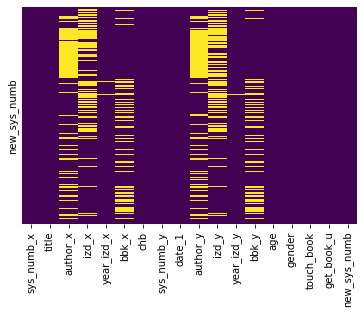

In [60]:
sns.heatmap(items_i.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [314]:
grap.clear()

In [315]:
G = nx.Graph()

In [316]:
new_sys_numb = df_title['new_sys_numb'].to_list()

In [317]:
G.add_nodes_from(new_sys_numb)

In [318]:
def complete_graph(gra, df_g, chb_key, n_s_b_key ):
    chb = df[chb_key].unique()
    for i_chb in tqdm(chb):
        n_s_n = df_g[df_g[chb_key] == i_chb][n_s_b_key].to_list()
        d = itertools.combinations(n_s_n, 2)   
        for item in d:
            subject_id, object_id = item
            if gra.has_edge(subject_id, object_id):
                G[subject_id][object_id]['weight'] += 1
            else:
                # new edge. add with weight=1
                G.add_edge(subject_id, object_id, weight=1)
                
    return gra

In [319]:
grap = complete_graph(G, df, 'chb', 'new_sys_numb') # добавляем веса в граф, если веса нет устанавливаем 1 если появилась еще одна связь добавляем 1

  0%|          | 0/10311 [00:00<?, ?it/s]

# создаем список пользователей взятых книг

In [310]:
def save_dict_to_file(dic, name_file):
    f = open(f'{name_file}.txt','w')
    f.write(str(dic))
    f.close()

def load_dict_from_file(name_file):
    f = open(f'{name_file}.txt','r')
    data=f.read()
    f.close()
    return eval(data)

In [123]:
def list_chb_book(df_b): # создаем список книг по каждому пользователю по убыванию  даты получения
    get_book_user={}
    chb = df['chb'].unique()
    df_b = df_b.sort_values(by = 'date_1', ascending=False).copy()
    for i in tqdm(chb):        
        one_user = []
        idex_row=[]
        #print(type(i))
        for s, row in df_b.iterrows():
            #print(type(row['chb']))
            if i == row['chb']:
                #print('chb the ->', row['chb'], 'and new_sys_numb ->', row['new_sys_numb'])
                one_user.append(row['new_sys_numb'])
                idex_row.append(s)
        df_b.drop(labels = idex_row, axis = 0, inplace = True)            
        get_book_user[i]=one_user
        # print(df_b['chb'].count())
    save_dict_to_file(get_book_user, 'get_book_user')    # сохраним т.к. заняло 20 часов

In [124]:
list_chb_book(df)

  0%|          | 0/10311 [00:00<?, ?it/s]

In [128]:
g_b_u=load_dict_from_file('get_book_user') #загрузим в переменную словарь с пользователь Х книги 

In [367]:
g_b_u['100001025944'][:5] #-------------------

[20683, 20776, 20689, 20678, 20647]

In [320]:
print(nx.subgraph(grap, [129893])) #-------------------

Graph with 1 nodes and 0 edges


In [321]:
print(*nx.common_neighbors(grap, 351, 353)) # общие соседи двух узлов графа #-------------------

275 276 352


In [322]:
print(*nx.all_neighbors(grap, 351)) # Возвращает все соседние узлы в графе. #-------------------

275 276 352 353 7697 8612 9047 21296 29164 49200 53491 53492 61569 61570 61571 61572 1455 61573 61574 61575 61576 61577 61578 61579 61580 61581 61582 61583 61584 61585 61586 61587 61588 61589 61590 61591 61592 61593 61594 16260 55644 61286 62464 69047 97601 116724 116725 116726 116727 116728 116729 116730 116731 116732 116733 116734


In [337]:
print(nx.path_weight(grap, [275, 351, 49200], 'weight')) # Возвращает общую стоимость, связанную с указанным путем и весом.е. #-------------------

2


In [338]:
weight_b = nx.get_edge_attributes(grap, 'weight') # создадим словарь с весами между книгами

In [339]:
save_dict_to_file(weight_b, 'weight_b') #-------------------

In [340]:
weight_b[(275, 276)] #-------------------

3530

In [341]:
print(df_title[df_title['new_sys_numb']==276]) #-------------------
print(df_title[df_title['new_sys_numb']==275]) # максимальное пересечение книг между пользователями

                                              title  new_sys_numb
275  С Рождеством Христовым! Изоматериал : Открытка           276
                                             title  new_sys_numb
274  С Рождеством Христовым Изоматериал : Открытка           275


In [562]:
users_reg = pd.read_csv('sample_solution.csv', sep=';', index_col=None, 
                    dtype={'chb': str})
u_reg=users_reg['chb'].unique()

In [563]:
u_reg

array(['100001051682', '300000798074', '200000875892', ...,
       '300001064154', '200001057984', '200001039283'], dtype=object)

In [579]:
def recomendat(u_reg):
    data=[]
    for u in tqdm(u_reg):
        #print(u)
        if u in g_b_u:
            u_get_book = user_U(g_b_u[u])
            for i in u_get_book:
                data.append([u, i])
        else: 
            for m in max_touch_book:
                data.append([u, m])
            
    df_t = pd.DataFrame(data, columns=['chb' , 'new_sys_numb'])
    return df_t

In [588]:
def user_U(u): # передаем список книг
    
    u_res = set()
    while len(u_res) < 20:
        for i in u :
            for ii in book_max_w(i):
                u_res.update({ii})
                u_res.difference(set(u))
                if len(u_res) == 20:
                    return u_res
        for im in max_touch_book:
            u_res.update({im})
            u_res.difference(set(u))
            if len(u_res) == 20:
                    return u_res
        
                   

In [581]:
def book_max_w(bok): # возращает список книг связанные с входной по индексам можно судить о мах связей

    
   # l_bok = nx.common_neighbors(grap, bok1, bok2) # общие соседи двух узлов графа #-------------------
    
    l_bok = list(nx.all_neighbors(grap, bok))
    l_bok.sort(key=lambda n: get_w(bok, n), reverse=True)
    return l_bok

In [582]:
def get_w(bok, bok_s):
    if bok < bok_s:
        return grap[bok][bok_s]['weight']
    else:
        return grap[bok_s][bok]['weight']

In [555]:
(user_U(g_b_u['200001039283']))

{20514,
 42973,
 56123,
 84121,
 87113,
 94004,
 102638,
 102639,
 102640,
 102641,
 102642,
 102643,
 102645,
 102646,
 102647,
 102648,
 102649,
 102650,
 102651,
 102652}

In [589]:
reg_df = recomendat(u_reg)

  0%|          | 0/16753 [00:00<?, ?it/s]

In [590]:
reg_df

,chb,new_sys_numb
0,100001051682,100171
1,100001051682,16560
2,100001051682,53759
3,100001051682,31726
4,100001051682,46013
...,...,...
335055,200001039283,16560
335056,200001039283,137977
335057,200001039283,103100
335058,200001039283,46013


In [591]:
t_df = df[['new_sys_numb', 'sys_numb']].copy()

In [592]:
t_df.drop_duplicates(subset='new_sys_numb')
t_dic = dict(t_df.values)

In [593]:
reg_df['new_sys_numb'] = reg_df['new_sys_numb'].apply(lambda x:t_dic[x])

In [594]:
reg_df.rename(columns={'new_sys_numb': 'sys_numb'}, inplace=True)

In [595]:
reg_df

,chb,sys_numb
0,100001051682,RSL01004357029
1,100001051682,RSL01006724299
2,100001051682,RSL01010175347
3,100001051682,RSL01007886433
4,100001051682,RSL01004400764
...,...,...
335055,200001039283,RSL01006724299
335056,200001039283,RSL01000193246
335057,200001039283,RSL01003955862
335058,200001039283,RSL01004400764


In [596]:
reg_df.to_csv('my_topT_solution.csv', index=False, sep=';')

In [461]:
df_max_touch_book = df.drop_duplicates(subset=['new_sys_numb']).copy()
#df[df['new_sys_numb'] == list(df['new_sys_numb'].unique()]

In [462]:
max_touch_book = list(df_max_touch_book.sort_values(by='touch_book', ascending=False)['new_sys_numb'].head(20))

In [463]:
max_touch_book

[100171,
 16560,
 53759,
 31726,
 46013,
 53760,
 53716,
 85036,
 17643,
 141840,
 31978,
 144616,
 109952,
 137977,
 103100,
 7653,
 14308,
 114774,
 55644,
 79888]